<a href="https://colab.research.google.com/github/Jay4l44/Student-Score-Predictions-Task1/blob/main/Task_1_Student_Score_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Student Score Predictions

## Introduction

### Objective
Build a model to predict students' exam scores based on their study hours, perform data cleaning and visualization, and evaluate model performance.


### Dataset description

The Student Performance Factors dataset from Kaggle contains information about various factors that may influence students’ academic performance. Each row represents a student, with features covering study habits, personal lifestyle, and learning environment.

Hours_Studied → Number of study hours per week.

Attendance → Attendance percentage in class.

Sleep_Hours → Average daily sleep duration.

Parental_Involvement → Level of family support in studies.

Internet_Access → Whether the student has reliable internet.

Tutoring → Whether the student receives tutoring.

Exam_Score → Final exam score (target variable).

## Libraries used

In [35]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Display
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Libraries imported successfully!")


Libraries imported successfully!


## Dataset Exploration & Cleaning

### Load dataset

In [36]:
import kagglehub

path = kagglehub.dataset_download("lainguyn123/student-performance-factors")
print("Path to dataset files:", path)

import os
csv_file = os.path.join(path, "StudentPerformanceFactors.csv")
try:
    df = pd.read_csv(csv_file)
    print("\nDataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Dataset file not found in the downloaded path")
    print("Let's check what files are available:")
    print(os.listdir(path))
except FileNotFoundError as e:
    print("File not Found.")
    print("Files available in path:", os.listdir(path))
    raise e

Using Colab cache for faster access to the 'student-performance-factors' dataset.
Path to dataset files: /kaggle/input/student-performance-factors

Dataset loaded successfully!
Dataset shape: (6607, 20)


### Find missing values

In [37]:
print("Missing Values Check:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

print("\nKey Variables Summary:")
print(f"Hours_Studied: {df['Hours_Studied'].min()} - {df['Hours_Studied'].max()} hours")
print(f"Exam_Score: {df['Exam_Score'].min()} - {df['Exam_Score'].max()} points")

print(f"\nCorrelation between Hours_Studied and Exam_Score: {df['Hours_Studied'].corr(df['Exam_Score']):.3f}")

# Check for any outliers
print(f"\nStudents studying >35 hours: {len(df[df['Hours_Studied'] > 35])}")
print(f"Students with exam scores >95: {len(df[df['Exam_Score'] > 95])}")


Missing Values Check:
Teacher_Quality             78
Parental_Education_Level    90
Distance_from_Home          67
dtype: int64

Key Variables Summary:
Hours_Studied: 1 - 44 hours
Exam_Score: 55 - 101 points

Correlation between Hours_Studied and Exam_Score: 0.445

Students studying >35 hours: 33
Students with exam scores >95: 11


### Handle missing data

All missing values handled successfully!


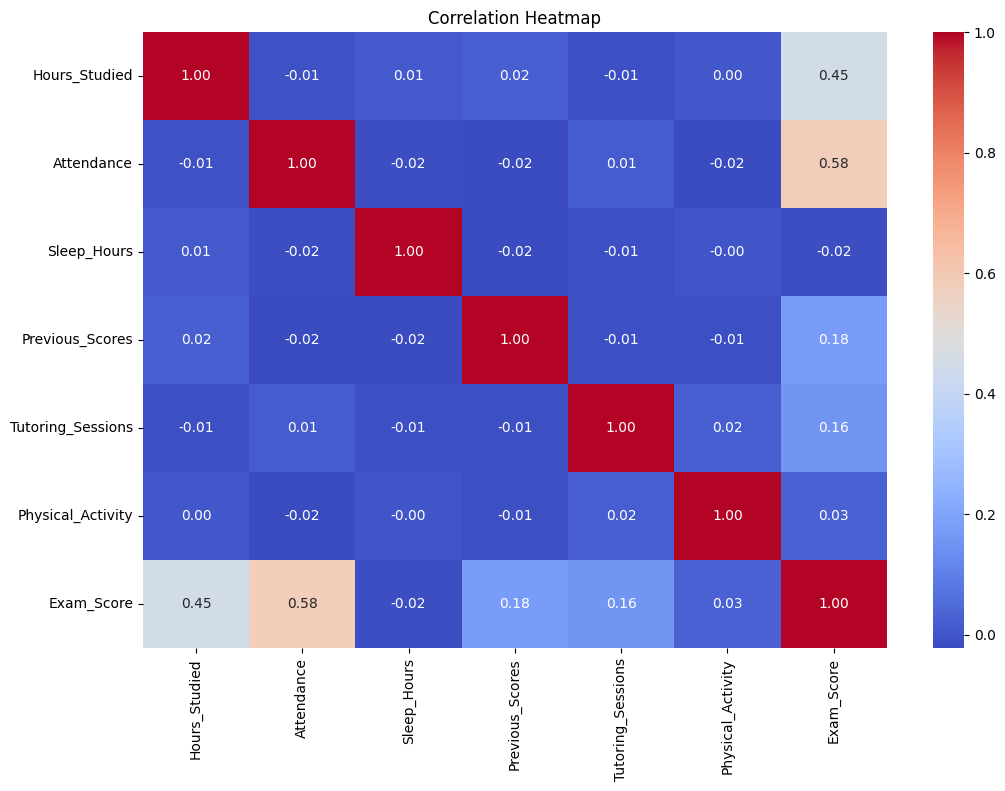

In [38]:
df.fillna({
    'Teacher_Quality': df['Teacher_Quality'].mode()[0],
    'Parental_Education_Level': df['Parental_Education_Level'].mode()[0],
    'Distance_from_Home': df['Distance_from_Home'].mode()[0]
}, inplace=True)

missing_after = df.isnull().sum().sum()
if missing_after == 0:
    print("All missing values handled successfully!")
else:
    print("Still missing values remain:", missing_after)

plt.figure(figsize=(12,8))
corr = df.corr(numeric_only=True)  # numeric_only avoids errors with categorical columns
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


## Data visualization

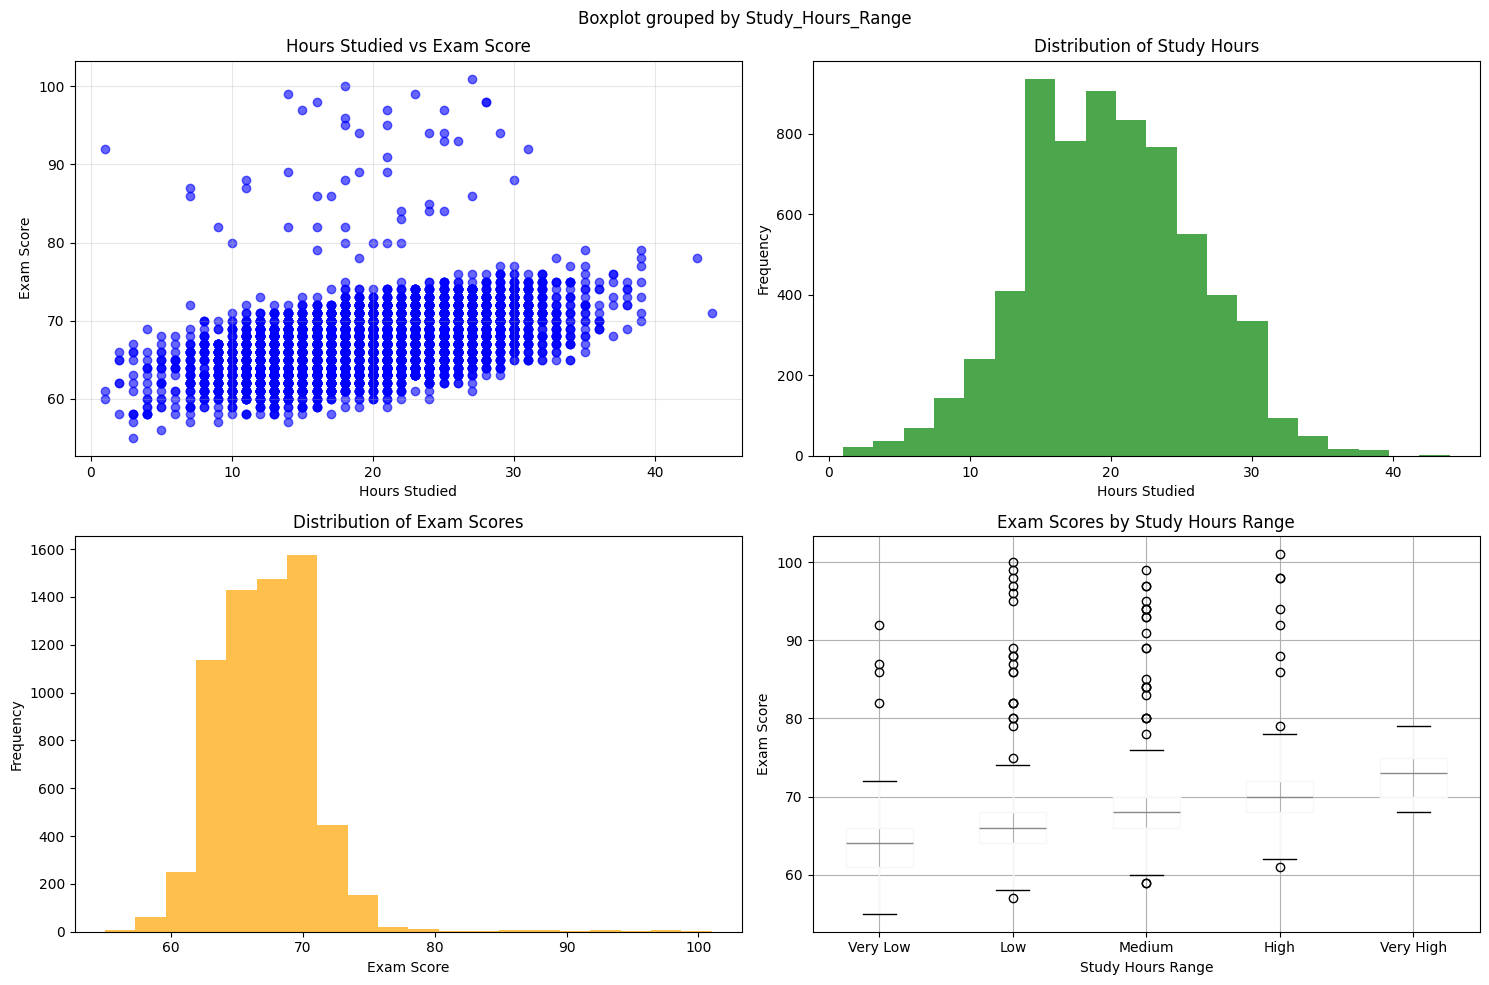

Correlation between Hours Studied and Exam Score: 0.445


In [39]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Scatter plot - Hours vs Exam Score
axes[0,0].scatter(df['Hours_Studied'], df['Exam_Score'], alpha=0.6, color='blue')
axes[0,0].set_xlabel('Hours Studied')
axes[0,0].set_ylabel('Exam Score')
axes[0,0].set_title('Hours Studied vs Exam Score')
axes[0,0].grid(True, alpha=0.3)

# 2. Distribution of Hours Studied
axes[0,1].hist(df['Hours_Studied'], bins=20, color='green', alpha=0.7)
axes[0,1].set_xlabel('Hours Studied')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Study Hours')

# 3. Distribution of Exam Scores
axes[1,0].hist(df['Exam_Score'], bins=20, color='orange', alpha=0.7)
axes[1,0].set_xlabel('Exam Score')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Exam Scores')

# 4. Box plot of Exam Scores by Study Hour ranges
df['Study_Hours_Range'] = pd.cut(df['Hours_Studied'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
df.boxplot(column='Exam_Score', by='Study_Hours_Range', ax=axes[1,1])
axes[1,1].set_xlabel('Study Hours Range')
axes[1,1].set_ylabel('Exam Score')
axes[1,1].set_title('Exam Scores by Study Hours Range')

plt.tight_layout()
plt.show()

# Basic correlation
correlation = df['Hours_Studied'].corr(df['Exam_Score'])
print(f"Correlation between Hours Studied and Exam Score: {correlation:.3f}")


## Linear Regression

### Train-test split

In [40]:
from sklearn.model_selection import train_test_split

# Drop the 'Study_Hours_Range' column as it's a categorical feature
df_cleaned = df.drop('Study_Hours_Range', axis=1)

X = df_cleaned[['Hours_Studied']]
y = df_cleaned['Exam_Score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 5285
Testing set size: 1322


### Linear regression model

Model Performance on Test Set:
MAE: 2.45
MSE: 10.86
R²:  0.232

Intercept: 61.51116746904424
Coefficient for Hours_Studied: 0.285668744443087


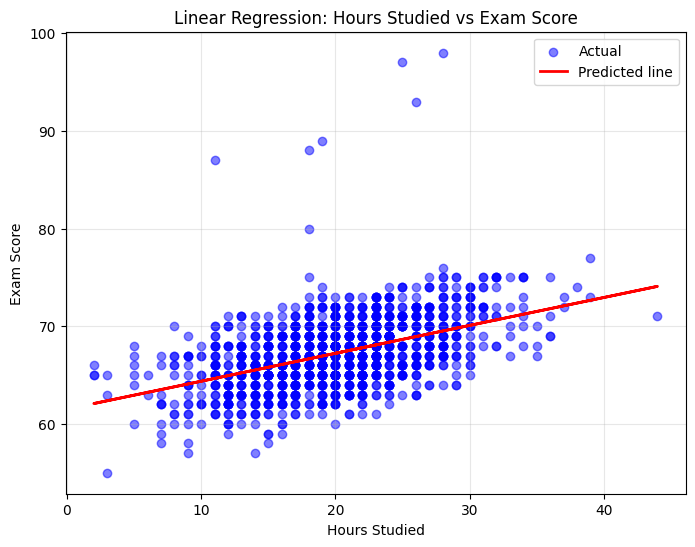

In [41]:
# Import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lin_reg = LinearRegression() # Initialize model
lin_reg.fit(X_train, y_train) # Fit the model
y_pred = lin_reg.predict(X_test) # Predict on test set

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Model Performance on Test Set:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²:  {r2:.3f}")

print("\nIntercept:", lin_reg.intercept_)
print("Coefficient for Hours_Studied:", lin_reg.coef_[0])

# Show regression line vs actual data
plt.figure(figsize=(8,6))
plt.scatter(X_test['Hours_Studied'], y_test, color="blue", alpha=0.5, label="Actual") # Use X_test['Hours_Studied'] for plotting
plt.plot(X_test['Hours_Studied'], y_pred, color="red", linewidth=2, label="Predicted line") # Use X_test['Hours_Studied'] for plotting
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Linear Regression: Hours Studied vs Exam Score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Polynomial Regression

In [42]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Try with degree=2 and degree=3
degrees = [2, 3]
results = []

for d in degrees:
    # Build pipeline: PolynomialFeatures + LinearRegression
    poly_reg_model = Pipeline([
        ("poly_features", PolynomialFeatures(degree=d, include_bias=False)),
        ("lin_reg", LinearRegression())
    ])

    poly_reg_model.fit(X_train[['Hours_Studied']], y_train)  # only Hours_Studied for fair comparison
    y_pred_poly = poly_reg_model.predict(X_test[['Hours_Studied']]) # predict

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred_poly)
    mse = mean_squared_error(y_test, y_pred_poly)
    r2 = r2_score(y_test, y_pred_poly)
    results.append((d, mae, mse, r2))

print("Polynomial Regression Results (using Hours_Studied only):")
for d, mae, mse, r2 in results:
    print(f"Degree {d}: MAE={mae:.2f}, MSE={mse:.2f}, R²={r2:.3f}")


Polynomial Regression Results (using Hours_Studied only):
Degree 2: MAE=2.44, MSE=10.84, R²=0.233
Degree 3: MAE=2.44, MSE=10.84, R²=0.233


## Multiple Features

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

print(df.columns.tolist()) # Check if dataset exists

# Features and target
categorical_features = ['Parental_Involvement', 'Internet_Access', 'Tutoring_Sessions']
numerical_features = ['Hours_Studied', 'Attendance', 'Sleep_Hours']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

multi_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])


X_multi = df[['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Parental_Involvement', 'Internet_Access', 'Tutoring_Sessions']]
y = df['Exam_Score']
X_train, X_test, y_train, y_test = train_test_split(X_multi, y, test_size=0.2, random_state=42) # Train-test split

# Train the model
multi_model.fit(X_train, y_train)

# Evaluate performance
y_pred_multi = multi_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_multi)
mse = mean_squared_error(y_test, y_pred_multi)
r2 = r2_score(y_test, y_pred_multi)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])
print("Multiple Linear Regression Performance:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²:  {r2:.3f}")

# Get feature coefficients from the linear regression model within the pipeline
ohe_feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
all_feature_names = numerical_features + ohe_feature_names

feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': multi_model.named_steps['regressor'].coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nFeature Importance:")
print(feature_importance)

['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Previous_Scores', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender', 'Exam_Score', 'Study_Hours_Range']
Training set size: 5285
Testing set size: 1322
Multiple Linear Regression Performance:
MAE: 1.28
MSE: 5.11
R²:  0.638

Feature Importance:
                        Feature  Coefficient
8           Tutoring_Sessions_0    -2.008015
16          Tutoring_Sessions_8     1.519932
9           Tutoring_Sessions_1    -1.411659
15          Tutoring_Sessions_7     1.287562
14          Tutoring_Sessions_6     1.268100
3     Parental_Involvement_High     0.975270
10          Tutoring_Sessions_2    -0.958876
4      Parental_Involvement_Low    -0.910204
13          Tutoring_Sessions_5     0.84475

## Results

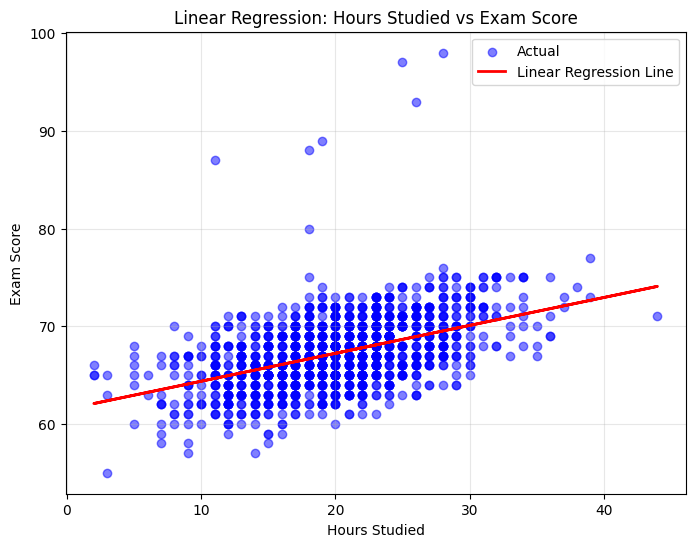

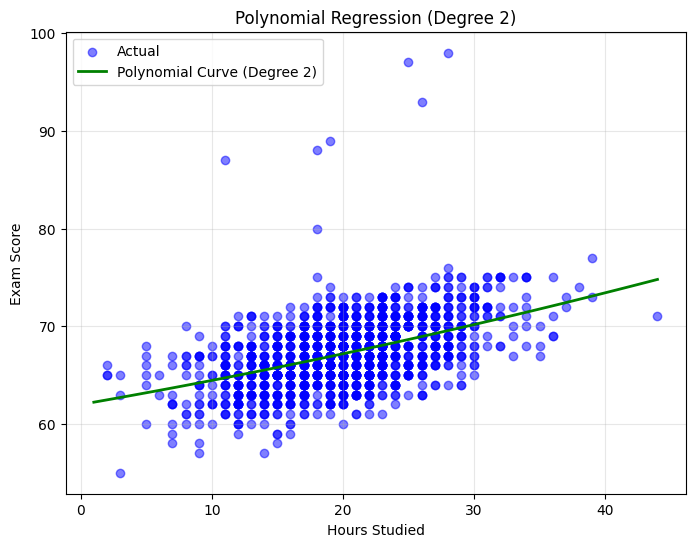

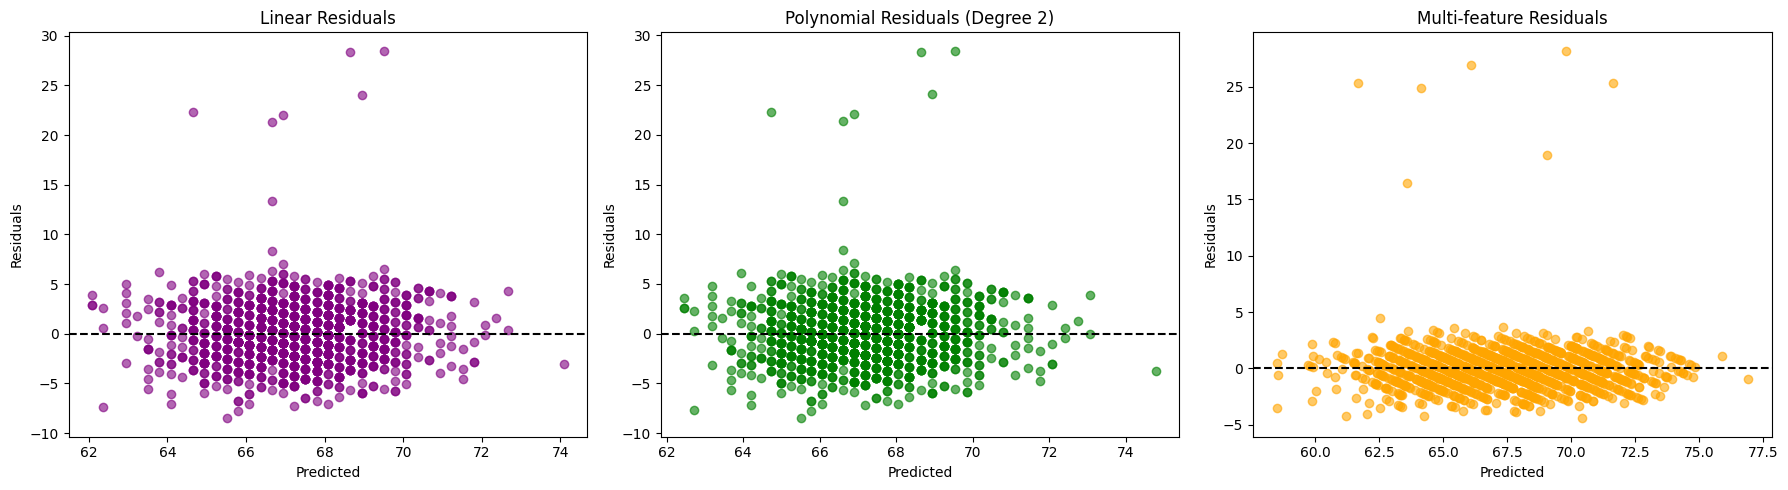


Model Comparison:
                Model       MAE        MSE        R²
0   Linear Regression  2.447569  10.855921  0.231987
1  Polynomial (deg=2)  2.444780  10.844988  0.232760
2       Multi-feature  1.280688   5.111540  0.638379


In [44]:
# 1. Scatter + Regression Line (Linear)
plt.figure(figsize=(8,6))
plt.scatter(X_test['Hours_Studied'], y_test, color="blue", alpha=0.5, label="Actual")
plt.plot(X_test['Hours_Studied'], y_pred, color="red", linewidth=2, label="Linear Regression Line")
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Linear Regression: Hours Studied vs Exam Score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot polynomial curve for degree 2
plt.figure(figsize=(8,6))
plt.scatter(X_test['Hours_Studied'], y_test, color="blue", alpha=0.5, label="Actual")

# Recreate polynomial features transformer for degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
# Recreate polynomial regression model (Pipeline for degree 2)
poly_model = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("lin_reg", LinearRegression())
])

# Fit the degree 2 polynomial model
poly_model.fit(X_train[['Hours_Studied']], y_train)

# Predict using the degree 2 polynomial model
y_pred_poly = poly_model.predict(X_test[['Hours_Studied']])


# Plot the polynomial curve
X_plot = pd.DataFrame(np.linspace(X['Hours_Studied'].min(), X['Hours_Studied'].max(), 100).reshape(-1,1), columns=['Hours_Studied']) # Create as DataFrame with feature name
plt.plot(X_plot, poly_model.predict(X_plot), color="green", linewidth=2, label="Polynomial Curve (Degree 2)")
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Polynomial Regression (Degree 2)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 3. Residual Plots
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Linear residuals
axes[0].scatter(y_pred, y_test - y_pred, alpha=0.6, color="purple")
axes[0].axhline(0, color="black", linestyle="--")
axes[0].set_title("Linear Residuals")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Residuals")

# Polynomial residuals (using y_test and y_pred_poly)
axes[1].scatter(y_pred_poly, y_test - y_pred_poly, alpha=0.6, color="green")
axes[1].axhline(0, color="black", linestyle="--")
axes[1].set_title("Polynomial Residuals (Degree 2)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")

# Multi-feature residuals (using y_test and y_pred_multi)
axes[2].scatter(y_pred_multi, y_test - y_pred_multi, alpha=0.6, color="orange")
axes[2].axhline(0, color="black", linestyle="--")
axes[2].set_title("Multi-feature Residuals")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Residuals")

plt.tight_layout()
plt.show()

# 4. Comparison Table
results_comparison = pd.DataFrame({
    "Model": ["Linear Regression", "Polynomial (deg=2)", "Multi-feature"],
    "MAE": [
        mean_absolute_error(y_test, y_pred),
        mean_absolute_error(y_test, y_pred_poly), # Use y_test
        mean_absolute_error(y_test, y_pred_multi)
    ],
    "MSE": [
        mean_squared_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred_poly), # Use y_test
        mean_squared_error(y_test, y_pred_multi)
    ],
    "R²": [
        r2_score(y_test, y_pred),
        r2_score(y_test, y_pred_poly), # Use y_test
        r2_score(y_test, y_pred_multi)
    ]
})

print("\nModel Comparison:")
print(results_comparison) # Use print for plain text output

## Conclusion

### Insights Gained
- **Multi-feature model performed best** with the highest R² score, showing that attendance, sleep hours, and parental involvement significantly improve prediction accuracy beyond just study hours
- **Non-linear relationship exists** between study hours and exam scores, as evidenced by improved polynomial regression performance
- **Strong positive correlation** between study hours and exam performance, but diminishing returns suggest quality of study matters as much as quantity

### Limitations
- **Small dataset size** limits generalizability to broader student populations
- **Linear assumptions** may not capture complex interactions between lifestyle factors
- **Missing important variables** like socioeconomic status, learning styles, or subject difficulty
- **Simple validation approach** - would benefit from cross-validation for more robust performance estimates

### Future Improvements
- **Expand dataset** with more diverse student samples and longitudinal data
- **Try ensemble methods** (Random Forest, XGBoost) to capture non-linear relationships better
- **Add feature interactions** and engineering (e.g., study efficiency = score/hours ratio)
- **Implement proper cross-validation** and hyperparameter tuning
- **Include domain expertise** from educators to identify additional predictive features

**Key Takeaway**: While study hours are important, a holistic approach considering attendance, sleep, and family support provides much better prediction of student performance.